In [1]:
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, RandomHorizontalFlip, RandomVerticalFlip
from sklearn.metrics import f1_score
from skimage.measure import label, regionprops
import numpy as np
from torchvision import transforms
from sklearn.metrics import f1_score,accuracy_score
import matplotlib.pyplot as plt
#from tqdm import tqdm
import tifffile
import skimage
torch.manual_seed(17)
import random
import time
from patchify import patchify, unpatchify
from skimage import measure

In [2]:
def padd_to_proper(data, target):
    padded_image = np.pad(data[:,53:-54,6:-10], ((0, 128-123), (0,0), (0, 0)), mode='constant')
    padded_target = np.pad(target[:,53:-54,6:-10], ((0, 128-123), (0,0), (0, 0)), mode='constant') 
    return padded_image[:,:,:-21], padded_target[:,:,:-21]

In [3]:
def swape(a):
    swapped_array = a.copy()
    # Replace 0s with 1s and 1s with 0s using boolean indexing
    swapped_array[a == 0] = 1
    swapped_array[a == 1] = 0
    return swapped_array

In [4]:
def f1(pred,target):
    pred = swape(pred)
    target = swape(target)
    
    F1 = round(100*f1_score(pred.astype('uint8').ravel(), target.astype('uint8').ravel()),3)
    return F1
    


In [5]:
data_path ='data/registered/output/fixed_low_res.tif'
data = tifffile.imread(data_path)
target_path = 'data/registered/output/registered_mask.tif'
target = tifffile.imread(target_path)

data , target = padd_to_proper(data,target)
data = data [1:117,1:-1,21:109]
target = target[1:117,1:-1,21:109]


print ('data shape = ',data.shape)
print ('target shape = ',target.shape)

NGMM_path = 'segmentation_outputs/NGMM_.tif'
NGMM_pred = tifffile.imread(NGMM_path)
print ('NGMMPred shape = ', NGMM_pred.shape)

RW_path = 'segmentation_outputs/RW.tif'
RW_pred = tifffile.imread(RW_path)
print ('RW_Pred shape = ', RW_pred.shape)

GrabCut_path = 'segmentation_outputs/GrabCut.tif'
GrabCut_pred = tifffile.imread(GrabCut_path)
print ('GrabCut_pred shape = ', GrabCut_pred.shape)

UNET_pred_path = 'segmentation_outputs/3D_Unet_32_32_32.tif'
UNET_pred = tifffile.imread(UNET_pred_path)[1:117,1:-1,21:109]
print ('Unet Pred shape = ', UNET_pred.shape)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Fabagh001\\Desktop\\Clean_Code\\6-Segmentation_comparison\\data\\registered\\output\\fixed_low_res.tif'

In [ ]:
def get_metrics (pred, target,voxel=60, ice_density =0.918  ):
    #ice_density (g/cm3)
    # Prediction accuracy
    #F1 score is calculated with swaped indecies so a buble is 1 and ice is zero
    F1_Score = f1(pred,target)
    ACC = round(100*accuracy_score(pred.astype('uint8').ravel(), target.astype('uint8').ravel()),3)
    # Microstructure parameters
    relative_density = round(len(pred[pred>0])/pred.size,3)
    density = relative_density * ice_density
    
    porosity = round (len (pred[pred==0])*100/pred.size,3)
    
    
    label_img = label(pred.astype('uint8'), connectivity=2,background = 1)
    props = regionprops(label_img)
    N_bubles = len(np.unique(label_img))
    Avg_area = np.array([i['area'] for i in props[:]]).mean()
    Avg_area =round( (Avg_area * voxel * voxel * voxel)/1000000000,5)
    
    verts, faces, _, _ = measure.marching_cubes(pred, level=0)
    surface_area = measure.mesh_surface_area(verts, faces)
    SSA =round( (surface_area * voxel * voxel)/1000000,2) # mm^2
    
    metrics = {'ACC':ACC, 'F1_Score':F1_Score, 'density':density, 'porosity':porosity,
               'N_bubles':N_bubles, 'Avg_bubble_Vol':Avg_area, 'SSA':SSA}
    return metrics

In [14]:
get_metrics(target[:30],target[:30])

{'ACC': 100.0,
 'F1_Score': 100.0,
 'density': 0.914328,
 'porosity': 0.446,
 'N_bubles': 54,
 'Avg_bubble_Vol': 0.00604,
 'SSA': 4.6}

In [15]:
get_metrics(NGMM_pred[:30]/100,target[:30])

{'ACC': 98.837,
 'F1_Score': 36.325,
 'density': 0.9051480000000001,
 'porosity': 1.38,
 'N_bubles': 31,
 'Avg_bubble_Vol': 0.03305,
 'SSA': 10.76}

In [16]:
get_metrics(GrabCut_pred[:30],target[:30])

{'ACC': 98.766,
 'F1_Score': 38.502,
 'density': 0.903312,
 'porosity': 1.561,
 'N_bubles': 35,
 'Avg_bubble_Vol': 0.03298,
 'SSA': 11.67}

In [17]:
get_metrics(RW_pred[:30],target[:30])

{'ACC': 99.475,
 'F1_Score': 52.54,
 'density': 0.911574,
 'porosity': 0.661,
 'N_bubles': 25,
 'Avg_bubble_Vol': 0.01978,
 'SSA': 5.28}

In [18]:
get_metrics(UNET_pred[:30],target[:30])

{'ACC': 99.619,
 'F1_Score': 51.77,
 'density': 0.915246,
 'porosity': 0.344,
 'N_bubles': 40,
 'Avg_bubble_Vol': 0.00634,
 'SSA': 3.56}

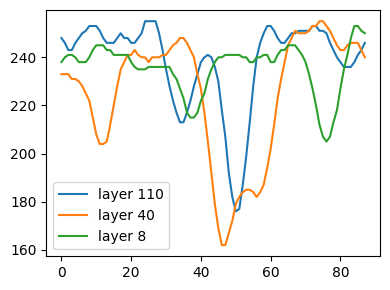

In [187]:
plt.figure(figsize=(4, 3))
plt.plot(data[110,95,:], label = 'layer 110')
plt.plot(data[40,45,:], label='layer 40')
plt.plot(data[8,90,:], label = 'layer 8')
plt.tight_layout()
plt.legend()
plt.savefig('layer_issues_2.png', dpi = 600)

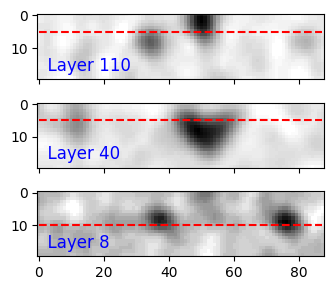

In [152]:
fig, ax = plt.subplots(3, 1,sharey=True,sharex=True, figsize=(7, 3))
ax[0].imshow(data[110,90:110,:],'gray')
ax[0].plot([0,87],[5,5], color='red',linestyle='--')
ax[0].set_title('  Layer 110',y=0, loc='left', color = 'blue')

ax[1].imshow(data[40,40:60,:],'gray')
ax[1].plot([0,87],[5,5], color='red',linestyle='--')
ax[1].set_title('  Layer 40',y=0, loc='left', color = 'blue')

ax[2].imshow(data[8,80:100,:],'gray')
ax[2].plot([0,87],[10,10], color='red',linestyle='--')
ax[2].set_title('  Layer 8',y=0, loc='left', color = 'blue')

plt.tight_layout()
plt.savefig('layer_issues_1.png', dpi = 600)

In [171]:
# Draw boundary
def DB(target,output,color):
    if target.max() < 200:
        new_target = np.zeros_like(target, dtype='uint8')
        new_target[target > 0.5] = 250
        new_target[target<=0.5] = 0
        color_image = cv2.cvtColor(new_target, cv2.COLOR_GRAY2BGR)
    else:
        color_image = cv2.cvtColor(target.astype('uint8'), cv2.COLOR_GRAY2BGR)*2
    

    #print ('color_image max',color_image.max())
    bn =skimage.segmentation.mark_boundaries( color_image,output.astype('uint8'), color, background_label=1)
    #print ('bn max',bn.max())
    return bn


In [172]:
def colored(img):
    return cv2.cvtColor((img).astype('uint8'), cv2.COLOR_GRAY2BGR)*2
    

C:\Users\Fabagh001\AppData\Local\Temp\ipykernel_255944\1104809162.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


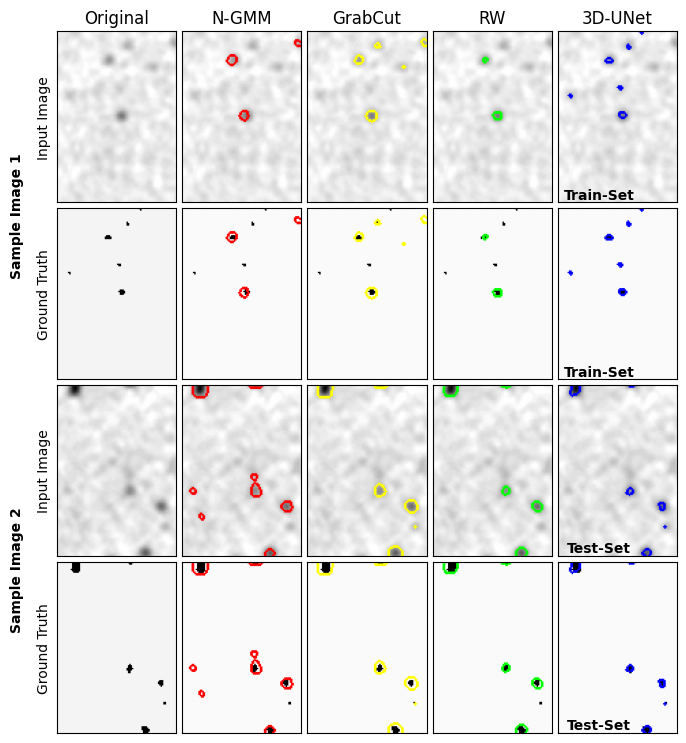

In [180]:
#target = target*255 # for better visulazition

n = 80 #train
m = 11 #test
figures = [colored(data[n]),
           DB(data[n],NGMM_pred[n],(1,0,0)),
           DB(data[n],GrabCut_pred[n],(1,1,0)),
           DB(data[n],RW_pred[n],(0,1,0)),
           DB(data[n],UNET_pred[n],(0,0,1)),
           
           colored(target[n]*250),
           DB(target[n],NGMM_pred[n],(1,0,0)),
           DB(target[n],GrabCut_pred[n],(1,1,0)),
           DB(target[n],RW_pred[n],(0,1,0)),
           DB(target[n],UNET_pred[n],(0,0,1)),
           
           colored(data[m]),
           DB(data[m],NGMM_pred[m],(1,0,0)),
           DB(data[m],GrabCut_pred[m],(1,1,0)),
           DB(data[m],RW_pred[m],(0,1,0)),
           DB(data[m],UNET_pred[m],(0,0,1)),
           
           colored(target[m]*250),
           DB(target[m],NGMM_pred[m],(1,0,0)),
           DB(target[m],GrabCut_pred[m],(1,1,0)),
           DB(target[m],RW_pred[m],(0,1,0)),
           DB(target[m],UNET_pred[m],(0,0,1))]

fig = plt.figure(figsize=(8, 12))
gs = fig.add_gridspec(4, 5, hspace=-0.55, wspace=0.05)
ll  = gs.subplots()
#fig.suptitle('Thresholding on High resolution')

for i , ax in enumerate(fig.get_axes()):
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticks([])
    ax.imshow(figures[i])


for ax in fig.get_axes():
    ax.label_outer()
    
# Add vertical text to the figure
vertical_text = "Sample Image 1"
x_pos = -30  
y_pos = 135 
# Note that rotation is set to 90 to make the text vertical
fig.get_axes()[0].text(x_pos, y_pos, vertical_text, rotation=90, va='center', ha='center', weight='bold')

vertical_text = "Sample Image 2"   
fig.get_axes()[10].text(x_pos, y_pos, vertical_text, rotation=90, va='center', ha='center', weight='bold')

vertical_text = "Train-Set"
x_pos = 30  
y_pos = 120
fig.get_axes()[4].text(x_pos, y_pos, vertical_text, va='center', ha='center', weight='bold')
fig.get_axes()[9].text(x_pos, y_pos, vertical_text, va='center', ha='center', weight='bold')
vertical_text = "Test-Set"
fig.get_axes()[14].text(x_pos, y_pos, vertical_text, va='center', ha='center', weight='bold')
fig.get_axes()[19].text(x_pos, y_pos, vertical_text, va='center', ha='center', weight='bold')

fig.get_axes()[0].set_title('Original')
fig.get_axes()[1].set_title('N-GMM')
fig.get_axes()[2].set_title('GrabCut')
fig.get_axes()[3].set_title('RW')
fig.get_axes()[4].set_title('3D-UNet')

fig.get_axes()[0].set_ylabel('Input Image')
fig.get_axes()[5].set_ylabel('Ground Truth')
fig.get_axes()[10].set_ylabel('Input Image')
fig.get_axes()[15].set_ylabel('Ground Truth')



#for ax in axes.ravel():
    #ax.axis("off")

fig.tight_layout()

plt.savefig('multiple_img.pdf', dpi = 600)
